# PRE

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [78]:
data = pd.read_csv("train.csv")
data = data

In [79]:
#check missing values
data.isnull().sum()

data['label'].value_counts()

0    5172
1    2976
Name: label, dtype: int64

In [101]:
###Pre-procesado

import re
import emoji
from spellchecker import SpellChecker
import spacy

# Cargar el modelo de spaCy
nlp = spacy.load('en_core_web_md')

# Crear instancia del corrector ortográfico
spell = SpellChecker()

# Añadir palabras al diccionario personal del corrector
personal_words = ["muslim", "islam", "url", "emoji", "trans"]
for word in personal_words:
    spell.word_frequency.load_words([word])

        
def preprocess_text(text, index, total):
    
    print(f"\rProcesando texto {index + 1} de {total}", end="", flush=True)
    
    # Reemplazar todas las URLs encontradas en el texto por la palabra "URL"
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, 'URL', text)
    
    # Convertir emojis a palabras descriptivas
    text = emoji.demojize(text)
    
    # Reemplazar emojis desemojizados con guiones bajos por espacios
    emoji_pattern = r'\b(\w+(?:_\w+)*)\b'
    text = re.sub(emoji_pattern, lambda x: ' '.join(x.group(1).split('_')), text)

    # Reemplazar dos emojis juntos unidos por :: con un espacio entre ellos
    double_emoji_pattern = r'::'
    text = re.sub(double_emoji_pattern, ' ', text)
    
    # Tokenización y lematización
    doc = nlp(text)
    tokens_lemmatized = [token.lemma_ for token in doc] 
    
    # Corrección de palabras mal escritas y eliminación de stopwords y caracteres especiales
    clean_tokens = []
    for token in tokens_lemmatized:
        if not nlp.vocab[token].is_stop and not nlp.vocab[token].is_punct and token.isalpha :
            # Verificar si la palabra está mal escrita
            if spell.unknown([token]):
                # Corregir la palabra mal escrita
                corrected_word = spell.correction(token)
                if corrected_word:
                    clean_tokens.append(corrected_word)
                else:
                    clean_tokens.append(token)  # Conservar la palabra original si la corrección es None
            else:
                clean_tokens.append(token)

    
    # Unir los tokens limpios en una cadena de texto nuevamente
    clean_text = " ".join(clean_tokens)
    
    return clean_text


# Aplicar el preprocesamiento al texto
#data=data[0:50]
total_texts = len(data)
data['clean_text'] = ""
for i, text in enumerate(data['text']):
    data['clean_text'][i] = preprocess_text(text, i, total_texts)
    
# Mostrar los primeros registros con el texto preprocesado
data


Procesando texto 8148 de 8148

,label,text,id,clean_text
0,0,"Hi Roy hope you are ok, Trans people are not g...",95e98db99c2,hi boy hope of Trans people gay thing s ram th...
1,0,But fuckin' hell what even is biology,a87b8708e63,fucking hell biology
2,0,Whose the nice looking clergyman?,5b3cb03803f,nice look clergyman
3,1,"AIDS ARE IN YOUR WAY, SIN HAS CONSEQUENCES AND...",5b0bad2347e,AIDS way SIN consequences bad
4,0,to learn,332048bd188,learn
...,...,...,...,...
8143,1,Yeah...if we still alive at the time of the ne...,9141edf7189,yeah alive time election happen fairly soon up...
8144,0,There is something fundamentally wrong with this,fde30735725,fundamentally wrong
8145,1,"This always confused me. If homosexuality is ""...",3d3456b6659,confuse homosexuality big deal proud normal ac...
8146,1,disgusting,eace075fe4d,disgust


In [102]:
#División de datos
X = data['clean_text']#.drop(['label', 'id', 'text'], axis=1)
y = data['label']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2, random_state=42)

#Vectorización
from sklearn.feature_extraction.text import TfidfVectorizer


In [103]:
from sklearn.svm import LinearSVC # 0.75
from sklearn.linear_model import LogisticRegression  # Regresión Logística 0.75
from sklearn.linear_model import LogisticRegressionCV  # 0.76 
from sklearn.linear_model import SGDClassifier  # 0.75 

from sklearn.ensemble import RandomForestClassifier  # Random Forest rnd 33 0.74
from sklearn.neural_network import MLPClassifier  # Redes Neuronales 0.69 máx 0.72
from sklearn.ensemble import GradientBoostingClassifier # 0.71

from xgboost import XGBClassifier # 0.72 0.74
from catboost import CatBoostClassifier # 0.74  logging_level= "Silent"
from sklearn.ensemble import AdaBoostClassifier # 0.72
from sklearn.ensemble import BaggingClassifier

from sklearn.pipeline import Pipeline

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression(solver='liblinear'))])

clf_lr = Pipeline([('tfidf', TfidfVectorizer()),
                   ('clf', LogisticRegressionCV( max_iter= 200))])

clf_rf = Pipeline([('tfidf', TfidfVectorizer()),('clf', XGBClassifier())])


from sklearn.ensemble import VotingClassifier

ensemble_clf = VotingClassifier(estimators=[
    ('svm', text_clf),
    ('lr', clf_lr),
   # ('cb', clf_cb),
    ('rf', clf_rf)
    ], voting='hard')

# Entrena el modelo
modelo= clf_lr

modelo.fit(X_train, y_train)

# Realiza predicciones
predictions = modelo.predict(X_test)



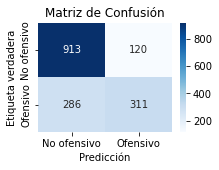

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1033
           1       0.72      0.52      0.61       597

    accuracy                           0.75      1630
   macro avg       0.74      0.70      0.71      1630
weighted avg       0.75      0.75      0.74      1630



In [104]:
# Obtener las puntuaciones de decisión para los datos de prueba
decision_scores = modelo.decision_function(X_test)

# Ajustar el umbral de decisión
threshold = -0.0
predictions = decision_scores > threshold

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, predictions)

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['No ofensivo', 'Ofensivo'], 
            yticklabels=['No ofensivo', 'Ofensivo'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

print(classification_report(y_test, predictions))

In [ ]:
# Cargar el conjunto de datos test
test_data = pd.read_csv("test_nolabel.csv")

test_data

In [146]:
# Aplicar el preprocesamiento al texto
test_data['clean_text'] = test_data['clean_text'].apply(preprocess_text)
test_data

,text,id,clean_text
0,Well media selected them exactly because they'...,ce40fcb3a33,medium select exactly stupid ignorant level sa...
1,We must stand together to return this mass of ...,02ca950343c,stand return mass people come need stand gover...
2,http://apologeticspress.org/APContent.aspx?cat...,a59e88b4f9c,http://apologeticspress.org/apcontent.aspx?cat...
3,"The UK has universal healthcare you dickwad, t...",ad62d80af38,universal healthcare dickwad medical cost cove...
4,Is that comment good for clergyman Paul Kosyl?,a6b36372f05,comment good clergyman paul kosyl
...,...,...,...
3488,This political party were neo-nazis in the 90s...,c42316663f5,political party neo nazi 90 clean act learn sp...
3489,You're fucking kidding me. I'm stupefied she i...,3e1b52d2030,fuck kid ism stupefy naive time fucking learni...
3490,Instead of caricaturing the whole Muslim and I...,fe66fe0f5cc,instead caricature muslin islamic community su...
3491,"sort out Is , and then they can go back!!!",3a5ca8a8fd5,sort


In [147]:
#Predicción
pred_new = modelo.predict(test_data["clean_text"])

In [148]:
predictions_df = pd.DataFrame({'id': test_data["id"], 'label': pred_new})

predictions_df.to_csv("LR_predictions.csv", index=False, header=True)
predictions_df

,id,label
0,ce40fcb3a33,1
1,02ca950343c,0
2,a59e88b4f9c,0
3,ad62d80af38,0
4,a6b36372f05,0
...,...,...
3488,c42316663f5,0
3489,3e1b52d2030,1
3490,fe66fe0f5cc,0
3491,3a5ca8a8fd5,0
